## About

In this notebook, I am trying to perform customer segmentation based on Recency, Frequency, Monetary Value Analysis (RFM Analysis) using data from an online store transactions.

I will use a clustering method using KMeans algorithm to cluster similar custmers in same groups.

At the end, I will deliver an interpertation of the results and analysis of segments.

#### Steps

- Importing and Exploring Dataset
- Customers Feature Extraction from data
- Preprocessing and Preparation for clustering
- Determining number of clusters
- Perform Clustering
- Show results and analysis of segements.

## About Dataset

This dataset represents transactions from a UK-based online retail store. [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/online+retail)

In [17]:
# import important packages
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [18]:
data = pd.read_csv("data/online_retail.csv")
data.head()

,Unnamed: 0,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,416792,572558,22745,POPPY'S PLAYHOUSE BEDROOM,6,2011-10-25,2.10,14286,United Kingdom
1,482904,577485,23196,VINTAGE LEAF MAGNETIC NOTEPAD,1,2011-11-20,1.45,16360,United Kingdom
2,263743,560034,23299,FOOD COVER WITH BEADS SET 2,6,2011-07-14,3.75,13933,United Kingdom
3,495549,578307,72349B,SET/6 PURPLE BUTTERFLY T-LIGHTS,1,2011-11-23,2.10,17290,United Kingdom
4,204384,554656,21756,BATH BUILDING BLOCK WORD,3,2011-05-25,5.95,17663,United Kingdom


In [19]:
data.head()

,Unnamed: 0,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,416792,572558,22745,POPPY'S PLAYHOUSE BEDROOM,6,2011-10-25,2.10,14286,United Kingdom
1,482904,577485,23196,VINTAGE LEAF MAGNETIC NOTEPAD,1,2011-11-20,1.45,16360,United Kingdom
2,263743,560034,23299,FOOD COVER WITH BEADS SET 2,6,2011-07-14,3.75,13933,United Kingdom
3,495549,578307,72349B,SET/6 PURPLE BUTTERFLY T-LIGHTS,1,2011-11-23,2.10,17290,United Kingdom
4,204384,554656,21756,BATH BUILDING BLOCK WORD,3,2011-05-25,5.95,17663,United Kingdom


In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68176 entries, 0 to 68175
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   68176 non-null  int64  
 1   InvoiceNo    68176 non-null  int64  
 2   StockCode    68176 non-null  object 
 3   Description  68176 non-null  object 
 4   Quantity     68176 non-null  int64  
 5   InvoiceDate  68176 non-null  object 
 6   UnitPrice    68176 non-null  float64
 7   CustomerID   68176 non-null  int64  
 8   Country      68176 non-null  object 
dtypes: float64(1), int64(4), object(4)
memory usage: 4.7+ MB


In [21]:
# check missing data
data.isna().sum()

Unnamed: 0     0
InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

### Preprocessing

In [22]:
# convert "InvoiceDate" column to datetime 
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'], format="%Y-%m-%d")

### Description Analysis

In [23]:
print("we have", data.shape[0], "Transactions for", data['CustomerID'].nunique(), "Customer in", data['Country'].unique()[0])
print("Transactions has been taken from", data['InvoiceDate'].min().strftime("%Y-%m-%d"), "to", data['InvoiceDate'].max().strftime("%Y-%m-%d"))

we have 68176 Transactions for 3643 Customer in United Kingdom
Transactions has been taken from 2010-12-10 to 2011-12-09


Text(0.5, 1.0, 'Distribution of "UnitPrice" attribute')

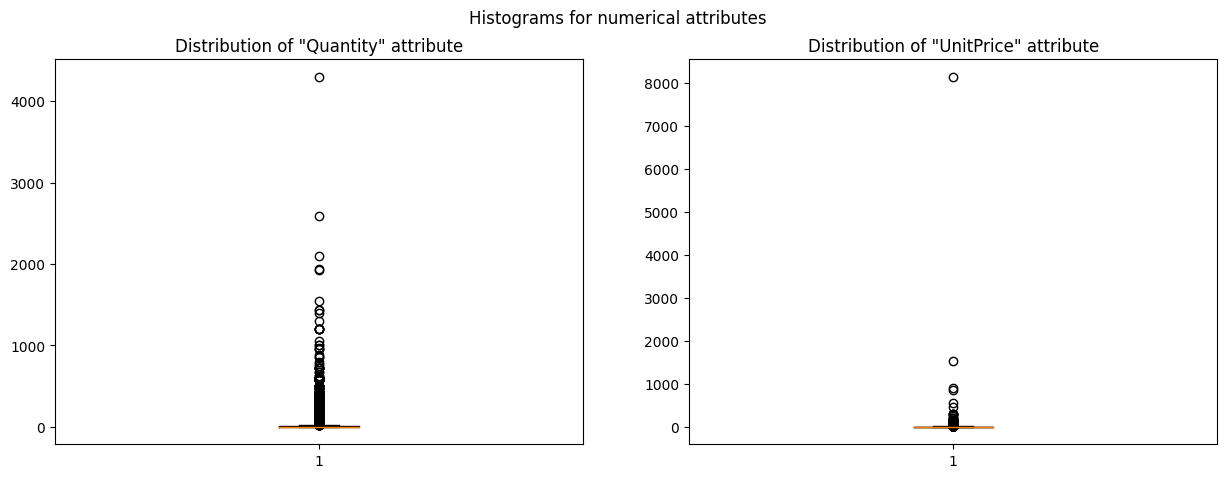

In [28]:
# Distribution of quantative data
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
fig.suptitle('Distribution of numerical attributes')

axes[0].boxplot(data['Quantity'])
axes[0].set_title("Distribution of \"Quantity\" attribute")

axes[1].boxplot(data['UnitPrice'])
axes[1].set_title("Distribution of \"UnitPrice\" attribute")

In [26]:
data['UnitPrice'].max()

8142.75